Необходимо проанализировать результаты эксперемента который проходил с 2024-03-01 по 2024-03-07 включительно. Для эксперимента были задействованы 2 и 1 группы. В группе два был использован новый алгоритм рекомендации постов, группа 1 контрольная. 

Гипотеза в том новый алгоритм во 2-й группе приведет к увеличению CTR.  Попробуем несколько тестов и графический анализ. Необходимо написать рекомендацию нужно ли раскатывать новый алгоритм на всех пользователей. 

In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pltgit 
import numpy as np
import hashlib # Делать хеши
import swifter # Ускорялка метода apply
from scipy import stats # Статистика
from scipy.stats import norm, ttest_ind
%matplotlib inline

from scipy.stats import mannwhitneyu

c:\Users\todur\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# создаёт словарь с именем connection, который содержит информацию для подключения к базе данных ClickHouse.
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20240320'
}

In [5]:
# скачиваем данные из clickhouse 
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2024-03-01' and '2024-03-07' and exp_group in (2,1)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection=connection)


In [6]:
df.head(3)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575


In [7]:
# разделим по группам
group_A = df[df.exp_group == 2].copy()
group_B = df[df.exp_group == 1].copy()

# Т-тест
сравним Т-тестом CTR группы А и группы В

In [8]:
# сравним Т-тестом CTR группы А и группы В
stats.ttest_ind(group_A.ctr, group_B.ctr, equal_var = False)

TtestResult(statistic=-0.4051491913112757, pvalue=0.685373331140751, df=15811.22649797086)

Т-тест утверждает что отличий нет(так как получили  pvalue=0.68).

# сглаженный CTR
сравним Т-тестом сглаженный CTR группы А и группы В

In [9]:
# функция для сглаженного CTR
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

# считаем общегрупповой CTR для группы А и В
global_ctr_A = df[df.exp_group == 2].likes.sum() / df[df.exp_group == 2].views.sum()
global_ctr_B = df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum()

In [10]:
# построим метрику сглаженного CTR для группы А и В
# (просто применим функцию, гиперпараметр присвоили 5)
group_A['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_A, 5), axis=1)

group_B['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_B, 5), axis=1)


In [11]:
display(group_A.head(2))
display(group_B.head(2))

,exp_group,user_id,likes,views,ctr,smothed_ctr
5,2,131473,9,108,0.083333,0.088507
6,2,23985,7,87,0.080460,0.086970


,exp_group,user_id,likes,views,ctr,smothed_ctr
0,1,109963,3,15,0.20000,0.202401
1,1,26117,32,141,0.22695,0.226356


In [12]:
# сравним Т-тестом сглаженные CTR группы А и группы В
stats.ttest_ind(group_A.smothed_ctr, group_B.smothed_ctr, equal_var = False)

TtestResult(statistic=-1.9460491517027683, pvalue=0.05166679015318526, df=15580.626569177026)

Получили pvalue=0.06  чуть больше 0,05 это означает что не отвергаем нулевую гипотезу, но ситуация совсем не одназназная. 

# Гистограма распределений
**Посмотрим как выглядят наши расспределения CTR**

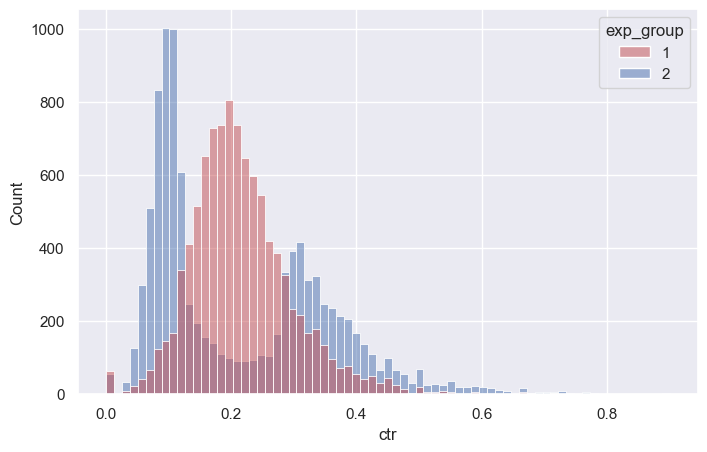

In [13]:
sns.set(rc={'figure.figsize':(8, 5)})
groups = sns.histplot(data=df,
                      x='ctr',
                      hue='exp_group',
                      palette = ['r', 'b'],
                      alpha=0.5,
                      kde=False)

Распределения полностью поменяли форму! В контрольной группе распределение осталось одногорбое похожее на нормальное, а в эксперементальной группе горба стало 2! 


Почему наш стандартный Т-тест не заметил различия? Потому, что средние значения почти не отличаются

In [14]:
# выведем средний CTR в группе А и В
global_ctr_A, global_ctr_B

(0.20025051027061783, 0.2096041628394293)

# Бутстрэп. 

Сравним группы А и В с помощью Бутстрэп

In [15]:
#на вход функция принимает лайки и просмотры по группам, а также указываем что бутстреп будет проводиться 2000 раз
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    # 2000 раз генерируем веса из расспределения пуассона для группы А и для группы В
    poisson_bootstraps1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)

    # считаем глобальный CTR для группы А и В(поскольку мы это делаем 2000 раз мы получаем расспределение 
    # из 2000 глобальных CTR для группы А и 2000 глобальных CTR для группы В)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    
    return globalCTR1, globalCTR2

In [18]:
# достанем из clickhouse данные по пользователям группы 1 и группы 2
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2024-03-01' and '2024-03-07' and exp_group in (1,2)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection=connection)

In [19]:
df.head(2)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.20000
1,1,26117,32,141,0.22695


In [20]:
# отделим лайки и просмотры для контрольной группы и тестовой
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [21]:
# применим функцию и получим распределение глобальных CTR 
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<Axes: ylabel='Count'>

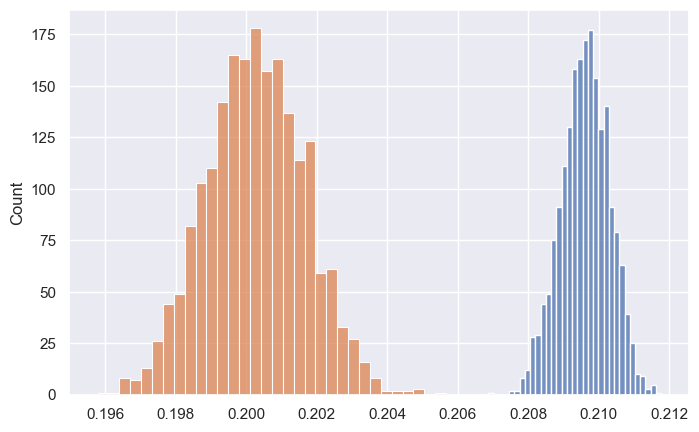

In [22]:
sns.histplot(ctr1)
sns.histplot(ctr2)

Как видно бутстрэп нам утверждает, что наш новый алгоритм(слева) значимо хуже(полностью разнесены распределения) чем наш старый алгоритм.

# Бакеты

Сделаем тест Мана-уитни поверх бакетов

In [23]:

q = """
SELECT exp_group, 
    xxHash64(user_id)%50 as bucket,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as bucket_ctr
 FROM {db}.feed_actions
    WHERE toDate(time) between '2024-03-01' and '2024-03-07' and exp_group in (1,2)
GROUP BY exp_group, bucket
"""
df = pandahouse.read_clickhouse(q, connection=connection)


In [24]:
df.head(2)

,exp_group,bucket,likes,views,bucket_ctr
0,1,0,2709,13505,0.200592
1,2,0,2613,13297,0.196510


In [25]:
# тест Манна-Уитни
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr,
                df[df.exp_group == 2].bucket_ctr,
                alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

Тест мана-уитни тоже видит значимое отличие. pvalue сильно меньше 0,05 

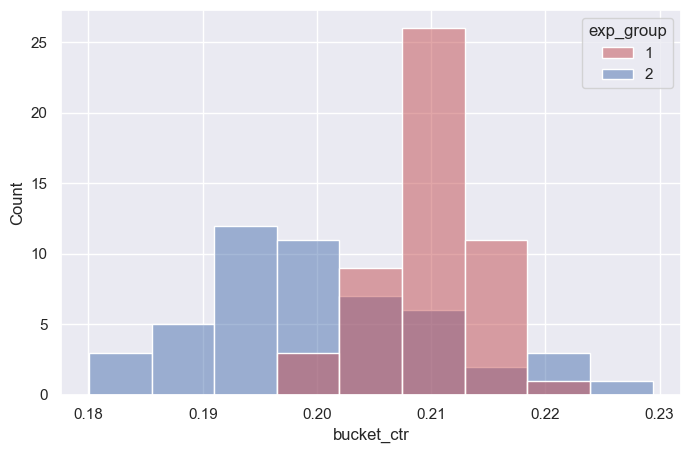

In [26]:
# нарисуем бакетное распределение
sns.set(rc={'figure.figsize':(8, 5)})
groups = sns.histplot(data=df,
                      x='bucket_ctr',
                      hue='exp_group',
                      palette = ['r', 'b'],
                      alpha=0.5,
                      kde=False)

Видим что бакетное распределение тоже явно отличаеться. 

**Вывод:**

**Финальное решение**


С точки зрения общегруппового CTR наш новый алгорит хуже. Это доказываеться бутстрэпом, тестом мана-уитни поверх бакетов. Это даже можно пронаблюдать глазами. 


Но в новом алгоритме есть несколько интересных моментов. Появились пользователи у которых CTR существено повысился. Если мы получаем большую часть денег именно с этих пользователей, то наша целевая метрика которую нужно сравнивать это не среднее значение CTR а какой нибудь соответствующий квантиль распределения CTR. 



Совершено точно этот тест полезен, но на всех пользователей его не стоит раскатывать. 